In [364]:
import math
from scipy.spatial.distance import cdist
import pandas as pd

# List to store customer objects
customers = []

# Matrix to store distances between customers
distance_matrix = []

class Customer:
    """
    Represents a customer in the vehicle routing problem.

    Attributes:
        cust_no (int): The customer number.
        x_coord (float): The x-coordinate of the customer's location.
        y_coord (float): The y-coordinate of the customer's location.
        demand (int): The demand of the customer.
        ready_time (int): The earliest time the customer is ready for service.
        due_date (int): The latest time the customer can be serviced.
        service_time (int): The time required to service the customer.
    """
    def __init__(self, cust_no, x_coord, y_coord, demand, ready_time, due_date, service_time):
        self.cust_no = cust_no
        self.x_coord = x_coord
        self.y_coord = y_coord
        self.demand = demand
        self.ready_time = ready_time
        self.due_date = due_date
        self.service_time = service_time

    def distance_to(self, other):
        """
        Calculates the distance to another customer.

        Parameters:
            other (Customer): The other customer to calculate the distance to.

        Returns:
            float: The distance to the other customer.
        """
        return distance_matrix[self.cust_no][other.cust_no]
    
    def __str__(self):
        return f"Customer {self.cust_no}"
    
    def __repr__(self):
        return self.__str__()

class Truck:
    """
    Represents a truck in the vehicle routing problem.

    Attributes:
        capacity (int): The capacity of the truck.
        route (list): The route of the truck, which is a list of customers.
        load (int): The current load of the truck.
        time (int): The current time of the truck.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.route = []
        self.load = 0
        self.time = 0

In [365]:
import random

class Ant:
    def __init__(self, customers, depot, trucks):
        """
        Initializes an Ant object.

        Parameters:
        customers (list): List of customer objects.
        depot (object): The depot (warehouse) object.
        trucks (list): List of truck objects.
        """
        self.customers = customers
        self.depot = depot
        self.trucks = trucks
        self.solution = []

    def construct_solution(self, pheromone, pheromone_importance, heuristic_importance):
        """
        Constructs a solution for the ant by assigning customers to trucks.
    
        Parameters:
        pheromone (list): Pheromone levels between customers.
        pheromone_importance (float): Pheromone importance factor.
        heuristic_importance (float): Heuristic importance factor.
        """
        unvisited = self.customers[:]
        random.shuffle(unvisited)
        for truck in self.trucks:
            truck.route = [self.depot]
            truck.load = 0
            truck.time = 0
            while unvisited:
                next_customer = self.select_next_customer(truck, unvisited, pheromone, pheromone_importance, heuristic_importance)
                if next_customer is None:
                    break
                travel_time_to_next = truck.route[-1].distance_to(next_customer)
                travel_time_to_depot = next_customer.distance_to(self.depot)
                # Check if adding the next customer allows the truck to return on time
                if truck.time + travel_time_to_next + next_customer.service_time + travel_time_to_depot > self.depot.due_date:
                    break
                truck.route.append(next_customer)
                truck.load += next_customer.demand
                truck.time += travel_time_to_next + next_customer.service_time
                unvisited.remove(next_customer)
            truck.route.append(self.depot)  # Return to the depot
        self.solution = [truck.route for truck in self.trucks]

    def select_next_customer(self, truck, unvisited, pheromone, pheromone_importance, heuristic_importance):
        """
        Selects the next customer for the truck to visit based on pheromone levels and heuristic information.
    
        Parameters:
        truck (object): The current truck object.
        unvisited (list): List of unvisited customer objects.
        pheromone (list): Pheromone levels between customers.
        pheromone_importance (float): Pheromone importance factor.
        heuristic_importance (float): Heuristic importance factor.
    
        Returns:
        object: The next customer object to visit, or None if no feasible customer is found.
        """
        feasible_customers = [
            c for c in unvisited 
            if truck.load + c.demand <= truck.capacity 
            and truck.time + truck.route[-1].distance_to(c) + c.service_time + c.distance_to(self.depot) <= self.depot.due_date
        ]
        if not feasible_customers:
            return None
        probabilities = []
        for customer in feasible_customers:
            pheromone_level = pheromone[truck.route[-1].cust_no][customer.cust_no]
            heuristic_value = 1 / (truck.route[-1].distance_to(customer) + 1e-6)
            probabilities.append((pheromone_level ** pheromone_importance) * (heuristic_value ** heuristic_importance))
        total = sum(probabilities)
        probabilities = [p / total for p in probabilities]
        return random.choices(feasible_customers, probabilities)[0]


In [366]:
import numpy as np

class ACO:
    def __init__(self, customers, depot, truck_count, truck_capacity, pheromone_importance=1.0, heuristic_importance=2.0, evaporation_rate=0.1, pheromone_init=1.0, iterations=100, ants_count=10):
        """
        Initializes the ACO algorithm with the given parameters.

        Parameters:
        customers (list): List of customer objects.
        depot (object): The depot (warehouse) object.
        truck_count (int): Number of trucks available.
        truck_capacity (int): Capacity of each truck.
        pheromone_importance (float): Importance of pheromone.
        heuristic_importance (float): Importance of heuristic information.
        evaporation_rate (float): Pheromone evaporation rate.
        pheromone_init (float): Initial pheromone level.
        iterations (int): Number of iterations to run the algorithm.
        ants_count (int): Number of ants to use in the algorithm.
        """
        self.customers = customers
        self.depot = depot
        self.truck_count = truck_count
        self.truck_capacity = truck_capacity
        self.pheromone_importance = pheromone_importance
        self.heuristic_importance = heuristic_importance
        self.evaporation_rate = evaporation_rate
        self.pheromone_init = pheromone_init
        self.iterations = iterations
        self.ants_count = ants_count
        self.pheromone = np.full((len(customers) + 1, len(customers) + 1), pheromone_init)
    
    def remove_unused_trucks(self, solution):
        return [route for route in solution if len(route) > 2] if solution else []  # Assuming each route includes the depot

    def run(self):
        """
        Runs the ACO algorithm to find the best solution.

        Returns:
        tuple: Best solution found and its cost.
        """
        best_solution = None
        best_cost = float('inf')
        for _ in range(self.iterations):
            ants = [Ant(self.customers, self.depot, [Truck(self.truck_capacity) for _ in range(self.truck_count)]) for _ in range(self.ants_count)]
            for ant in ants:
                ant.construct_solution(self.pheromone, self.pheromone_importance, self.heuristic_importance)
                cost = self.calculate_distance_cost(ant.solution)
                if cost < best_cost:
                    best_cost = cost
                    best_solution = ant.solution
            self.update_pheromone(ants)
        return best_solution, best_cost

    def calculate_distance_cost(self, solution):
        """
        Calculates the cost of a given solution.

        Parameters:
        solution (list): A list of routes, where each route is a list of customers.

        Returns:
        float: The total cost of the solution.
        """
        return sum(sum(route[i].distance_to(route[i + 1]) for i in range(len(route) - 1)) for route in solution)

    def update_pheromone(self, ants):
        """
        Updates the pheromone levels based on the solutions found by the ants.

        Parameters:
        ants (list): List of ant objects that have constructed solutions.
        """
        self.pheromone *= (1 - self.evaporation_rate)
        for ant in ants:
            for route in ant.solution:
                for i in range(len(route) - 1):
                    self.pheromone[route[i].cust_no][route[i + 1].cust_no] += 1 / self.calculate_distance_cost(ant.solution)

In [367]:
import matplotlib.pyplot as plt

colors = [
    "#0000FF",  # Blue
    "#FF0000",  # Red
    "#008000",  # Green
    "#FFA500",  # Orange
    "#800080",  # Purple
    "#00FFFF",  # Cyan
    "#FF00FF",  # Magenta
    "#FFFF00",  # Yellow
    "#FFC0CB",  # Pink
    "#A52A2A",  # Brown
    "#00FF00",  # Lime
    "#008080",  # Teal
    "#000080",  # Navy
    "#800000",  # Maroon
    "#FFD700",  # Gold
    "#EE82EE",  # Violet
    "#4B0082",  # Indigo
    "#808000",  # Olive
    "#40E0D0",  # Turquoise
    "#808080"   # Gray
]

def plot_routes(solution, depot):
    plt.figure(figsize=(10, 8))
    for i in range(len(solution)):
        route = solution[i]
        route_x = [depot.x_coord] + [customer.x_coord for customer in route[1:-1]] + [depot.x_coord]
        route_y = [depot.y_coord] + [customer.y_coord for customer in route[1:-1]] + [depot.y_coord]
        plt.plot(route_x, route_y, marker='o', color=colors[i % len(colors)], label=f'Truck {i + 1}')
        # Show name on the point
        for i, customer in enumerate(route[1:-1]):
            plt.text(customer.x_coord, customer.y_coord, f"{customer.cust_no}", fontsize=9, ha='center', va='center')
    plt.scatter(depot.x_coord, depot.y_coord, c='red', label='Depot', s=100, marker='x')
    plt.title('Truck Routes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.legend()
    plt.show()
    
def print_truck_usage(solution, depot):
    """
    Prints the capacity used by each truck, the total distance, and the total time for each route.
    Also plots the routes for each truck.

    Parameters:
    solution (list): A list of routes, where each route is a list of customers.
    depot (Customer): The depot (warehouse) object.
    """
    truck_count = 0  # Initialize the truck count
    max_global_time = 0 # Initialize the total time
    max_distance = 0 # Initialize the total distance

    for i, route in enumerate(solution):  # Iterate over each route in the solution
        load = sum(customer.demand for customer in route[1:-1])  # Calculate the load for the current route
        if load > 0:  # If the load is greater than 0
            truck_count += 1  # Increment the truck count

            # Calculate the total distance for the current route
            total_distance = sum(route[j].distance_to(route[j+1]) for j in range(len(route) - 1))

            # Calculate the total time for the current route
            total_time = sum(customer.service_time for customer in route[1:-1]) + total_distance  # Assuming time is proportional to distance
            
            if max_global_time < total_time:
                max_global_time = total_time
                
            max_distance += total_distance

            # Print the details for the current truck
            print('-' * 50)
            print(f"Truck #{i + 1}")
            print(f"Path: depot -> {''.join([f'{customer.cust_no} -> ' for customer in route[1:-1]])}depot")
            print(f"Capacity used = {load}")
            print(f"Total distance = {total_distance:.2f}")
            print(f"Total time = {total_time:.2f}")

            # Plot the route
            plt.figure()  # Create a new figure for each truck
            route_x = [depot.x_coord] + [customer.x_coord for customer in route[1:-1]] + [depot.x_coord]
            route_y = [depot.y_coord] + [customer.y_coord for customer in route[1:-1]] + [depot.y_coord]
            plt.plot(route_x, route_y, marker='o', color=colors[i % len(colors)], label=f'Truck {i + 1}')
            for customer in route[1:-1]:
                plt.text(customer.x_coord, customer.y_coord, f"{customer.cust_no}", fontsize=9, ha='center', va='center')

            plt.scatter(depot.x_coord, depot.y_coord, c='red', label='Depot', s=100, marker='x')
            plt.title(f'Truck {i + 1} Route')
            plt.xlabel('X Coordinate')
            plt.ylabel('Y Coordinate')
            plt.grid(True)
            plt.legend()
            plt.show()

    print('-' * 100)
    print(f"Total number of trucks used: {truck_count}")  # Print the total number of trucks used
    print(f"Max distance: {max_distance:.2f}")  # Print the total number of trucks
    print(f"Max global time: {max_global_time:.2f}")  # Print the total number of trucks used

In [368]:
def instance_generator(customer_count, rand_seed=0):
    """
    Generates a random instance of the vehicle routing problem.

    Returns:
    tuple: List of customer objects and the depot object., number of trucks, capacity of each truck
    """
    random.seed(rand_seed)  # Set the random seed for reproducibility
    
    # Number of trucks
    truck_count = random.randint(10, 75)
    
    # Capacity of each truck
    capacity = random.randint(10, 50) * 10

    # Number of customers
    num_customers = customer_count
    
    # Generate random service time for the customer
    service_time = random.randint(1, 5) * 10

    for i in range(1, num_customers + 1):

        # Generate random demand for the customer
        demand = random.randint(1, 10) * 10
        
        # Generate random coordinates for the customer
        x_coord = random.uniform(0, 100)
        y_coord = random.uniform(0, 100)

        # Generate random ready time for the customer
        ready_time = random.randint(0, 1000)

        # Generate random due date for the customer
        due_date = ready_time + random.randint(100, 300)

        # Create a Customer object and add it to the list of customers
        customers.append(Customer(i, x_coord, y_coord, demand, ready_time, due_date, service_time))

    # Generate the depot (warehouse) at the center of the customers
    depot = Customer(0, sum(customer.x_coord for customer in customers) / num_customers, sum(customer.y_coord for customer in customers) / num_customers, 0, 0, max(x.due_date for x in customers) + service_time + 100, 0)

    return [depot] + customers, truck_count, capacity

Number of trucks: 25
Capacity of each truck: 200
Number of customers: 100


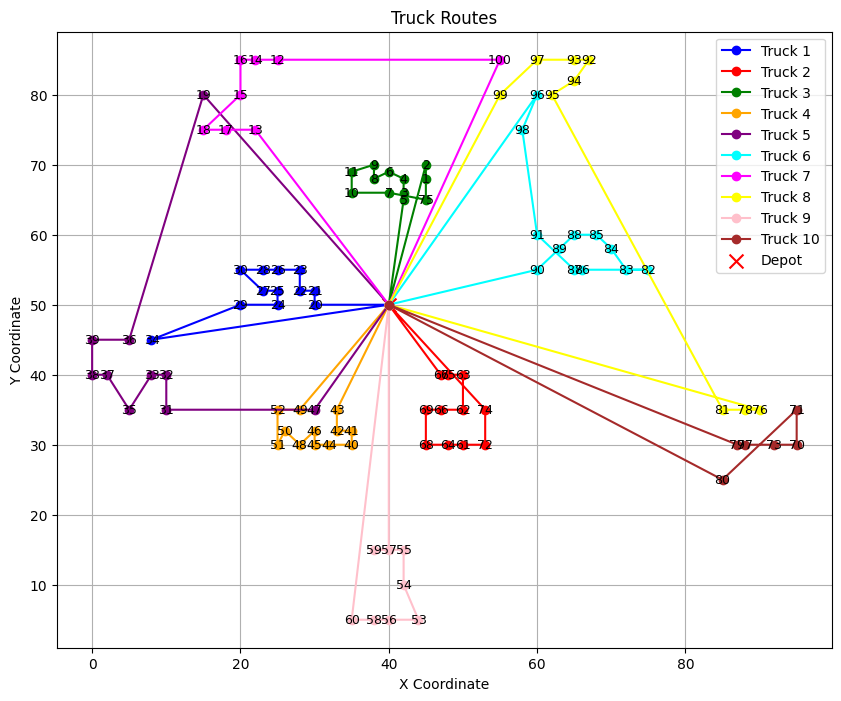

--------------------------------------------------
Truck #1
Path: depot -> 20 -> 21 -> 22 -> 23 -> 26 -> 28 -> 30 -> 27 -> 25 -> 24 -> 29 -> 34 -> depot
Capacity used = 190
Total distance = 83.63
Total time = 1163.63


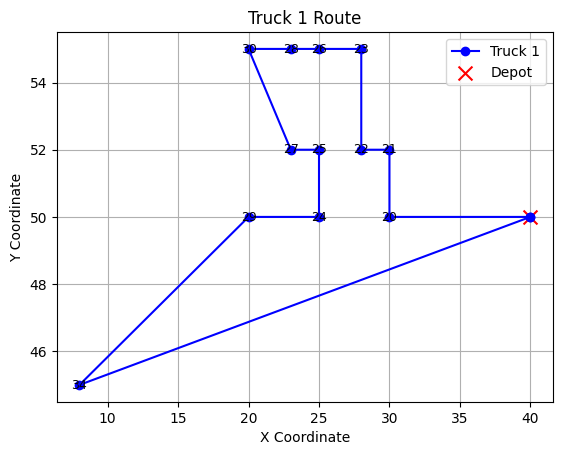

--------------------------------------------------
Truck #2
Path: depot -> 67 -> 65 -> 63 -> 62 -> 66 -> 69 -> 68 -> 64 -> 61 -> 72 -> 74 -> depot
Capacity used = 200
Total distance = 63.06
Total time = 1053.06


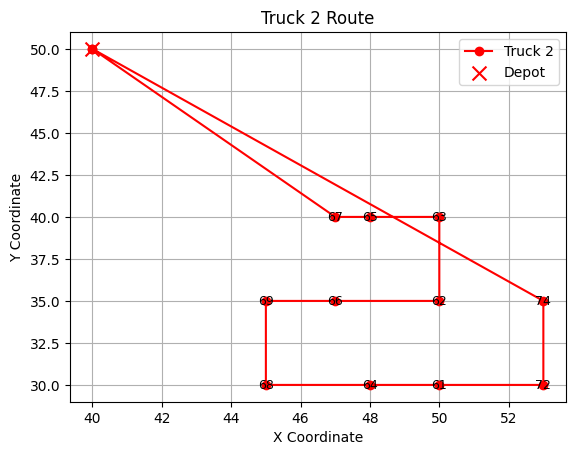

--------------------------------------------------
Truck #3
Path: depot -> 5 -> 3 -> 4 -> 6 -> 8 -> 9 -> 11 -> 10 -> 7 -> 75 -> 1 -> 2 -> depot
Capacity used = 180
Total distance = 66.48
Total time = 1146.48


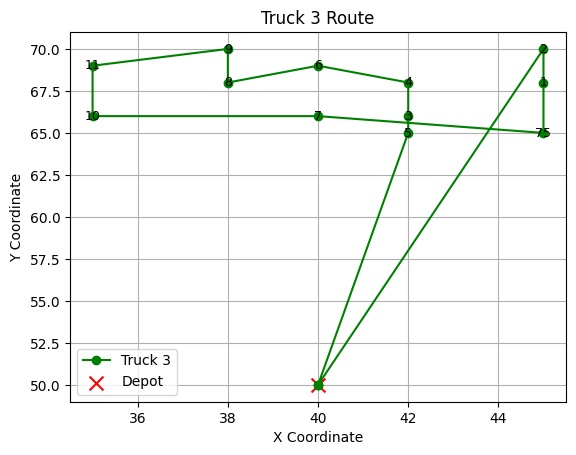

--------------------------------------------------
Truck #4
Path: depot -> 43 -> 42 -> 41 -> 40 -> 44 -> 45 -> 46 -> 48 -> 50 -> 51 -> 52 -> 49 -> depot
Capacity used = 150
Total distance = 65.66
Total time = 1145.66


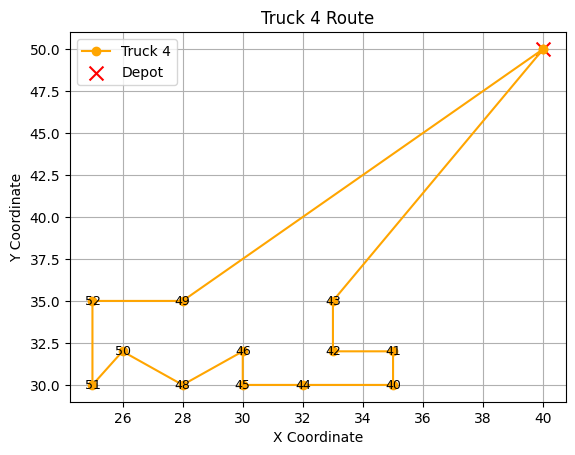

--------------------------------------------------
Truck #5
Path: depot -> 47 -> 31 -> 32 -> 33 -> 35 -> 37 -> 38 -> 39 -> 36 -> 19 -> depot
Capacity used = 200
Total distance = 144.14
Total time = 1044.14


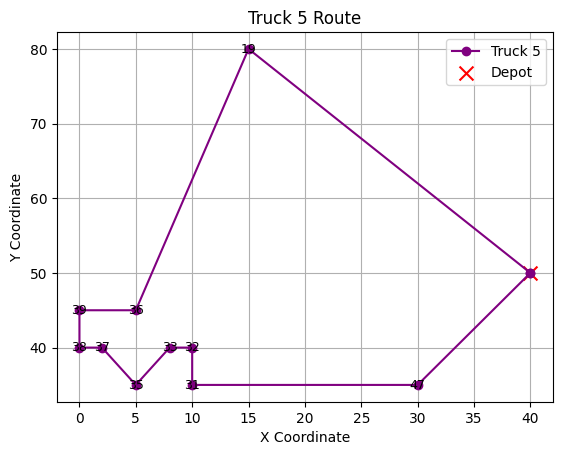

--------------------------------------------------
Truck #6
Path: depot -> 90 -> 89 -> 88 -> 85 -> 84 -> 83 -> 82 -> 86 -> 87 -> 91 -> 98 -> 96 -> depot
Capacity used = 200
Total distance = 113.77
Total time = 1193.77


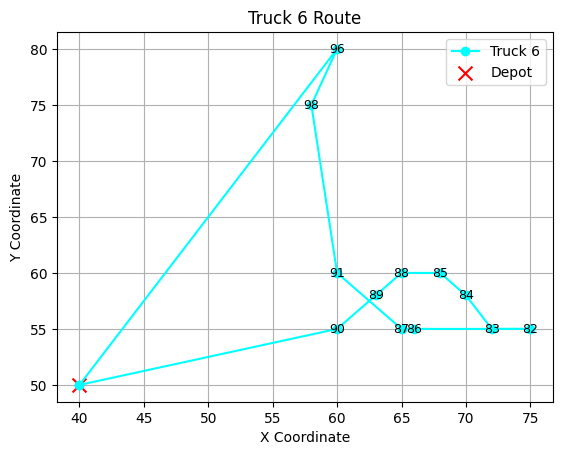

--------------------------------------------------
Truck #7
Path: depot -> 13 -> 17 -> 18 -> 15 -> 16 -> 14 -> 12 -> 100 -> depot
Capacity used = 200
Total distance = 122.96
Total time = 842.96


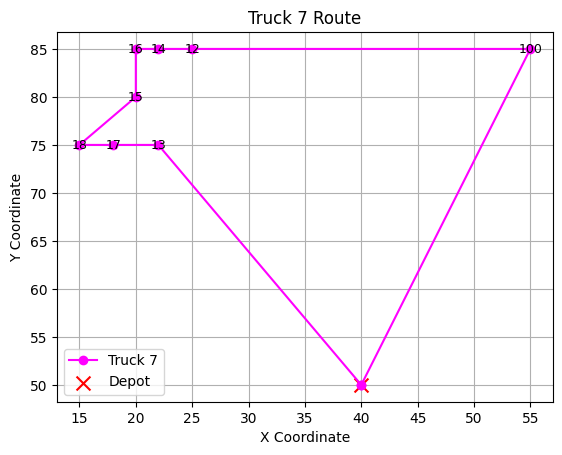

--------------------------------------------------
Truck #8
Path: depot -> 99 -> 97 -> 93 -> 92 -> 94 -> 95 -> 81 -> 78 -> 76 -> depot
Capacity used = 200
Total distance = 162.56
Total time = 972.56


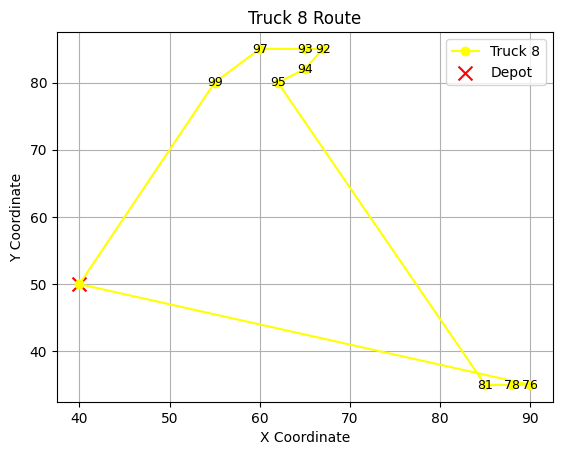

--------------------------------------------------
Truck #9
Path: depot -> 57 -> 59 -> 55 -> 54 -> 53 -> 56 -> 58 -> 60 -> depot
Capacity used = 200
Total distance = 105.66
Total time = 825.66


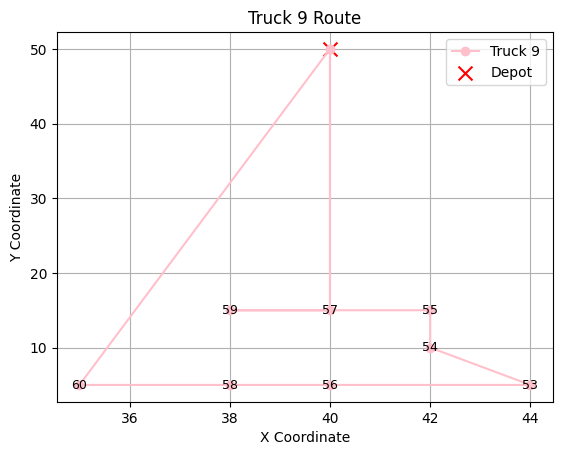

--------------------------------------------------
Truck #10
Path: depot -> 79 -> 77 -> 73 -> 70 -> 71 -> 80 -> depot
Capacity used = 90
Total distance = 129.70
Total time = 669.70


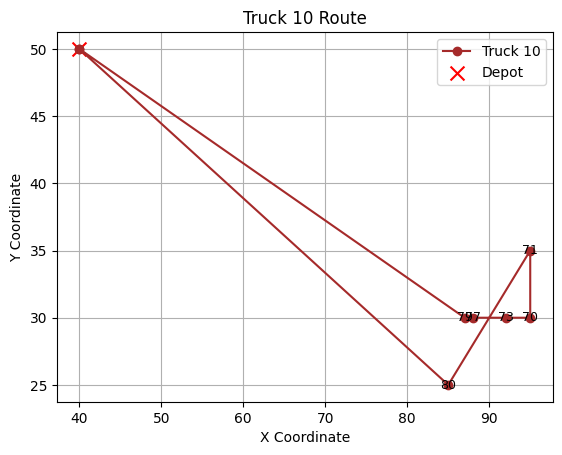

----------------------------------------------------------------------------------------------------
Total number of trucks used: 10
Max distance: 1057.61
Max global time: 1193.77


In [369]:
if __name__ == '__main__':
    file_path = 'dataset/c101.txt'  # Path to the input file

    # Reading the vehicle data (lines 3-4)
    vehicle_df = pd.read_csv(file_path, skiprows=4, nrows=1, sep='\\s+', names=['Number', 'Capacity'])
    
    # Reading the customer data (after line 9)
    customers_df = pd.read_csv(file_path, skiprows=9, sep='\\s+', names=['Cust No.', 'XCoord.', 'YCoord.', 'Demand', 'Ready Time', 'Due Date', 'Service Time'])

    truck_count = vehicle_df['Number'][0]  # Get the number of trucks
    capacity = vehicle_df['Capacity'][0]  # Get the capacity of each truck

    # Create a list of Customer objects from the customer data
    customers = [Customer(row['Cust No.'], row['XCoord.'], row['YCoord.'], row['Demand'], row['Ready Time'], row['Due Date'], row['Service Time']) for index, row in customers_df.iterrows()]
    
    # customers, truck_count, capacity = instance_generator(10)  # Generate a random instance of the vehicle routing problem
    
    # Print the vehicle data
    print(f"Number of trucks: {truck_count}")
    print(f"Capacity of each truck: {capacity}")
    print(f"Number of customers: {len(customers) - 1}")
    
    # Calculate the distance matrix between customers
    distance_matrix = cdist([[customer.x_coord, customer.y_coord] for customer in customers], [[customer.x_coord, customer.y_coord] for customer in customers], 'euclidean')
    
    # Define the depot (warehouse) as the last customer in the list
    warehouse = customers.pop(0)

    # Initialize the Ant Colony Optimization (ACO) algorithm
    aco = ACO(
        customers,
        warehouse,
        truck_count=truck_count,
        truck_capacity=capacity,
        iterations=30,
        ants_count=75,
        pheromone_importance=1.0,
        heuristic_importance=100,
        evaporation_rate=0.1,
        pheromone_init=5.0
    )
    
    # aco = ACO(
    #     customers, 
    #     warehouse, 
    #     truck_count=truck_count, 
    #     truck_capacity=capacity, 
    #     iterations=100,  # Increase iterations for better exploration
    #     ants_count=15,  # Increase the number of ants for more solutions
    #     heuristic_importance=200,  # Increase heuristic importance to focus on distance
    #     evaporation_rate=0.1,  # Decrease evaporation rate to reduce pheromone influence
    #     pheromone_init=10.0  # Lower initial pheromone to reduce its initial influence
    # )

    # Run the ACO algorithm to find the best solution
    best_solution, best_cost = aco.run()
    # print("Best solution:", best_solution)  # Print the best solution found
    # print("Best cost:", best_cost)  # Print the cost of the best solution
    
    best_solution = aco.remove_unused_trucks(best_solution)  # Remove unused trucks from the solution
    
    # Plot the routes of the best solution
    plot_routes(best_solution, warehouse)
    
    # Print the truck usage details
    print_truck_usage(best_solution, warehouse)